# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Утилиты

### Импорты

In [ ]:
!pip install numpy==1.22
!pip install -U scikit-learn
!pip install matplotlib==3.5

In [2]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm


RANDOM_STATE = 42

### Вспомогательные функции

#### Описание данных

In [3]:
def full_info(df:pd.DataFrame) -> None:
    '''
    На вход функция принимает таблицу, выводит первые 5 строк,
    типы данных, пропуски, явные дубликаты, основные статистики
    '''
    display(df.head())
    print('Типы данных')
    display(df.info())
    print('\nПропуски')
    display(df.isna().sum())
    print('\nЯвные дубликаты')
    display(df.duplicated().sum())
    print('\nОсновные статистики')
    display(df.describe())

#### Графики для исследовательского анализа

In [4]:
def plotting_stat_graphs(
        data,
        target=None,
        discrete_threshold=20
) -> None:
    '''
    На вход подается pandas.DataFrame или pandas.Series
    Строятся графики для статистического анализа:
        Для численных столбцов строится гистограмма и ящик с усами, 
        Если данные дискретные - строится как и для категориальных
        барплот и круговая диаграмма
    Если указан target, то гистограммы строятся с учетом разделения по таргетам
    '''
    if target and target not in data.columns:
        print('Неверное значение target')
        return
    if isinstance(data, pd.DataFrame):
        numeric_cols = pd.DataFrame(
            data.nunique(),
            columns=['counts']
        ).query('counts > @discrete_threshold').index
        non_numeric_cols = pd.DataFrame(
            data.nunique(),
            columns=['counts']
        ).query('counts <= @discrete_threshold').index

        for col in numeric_cols:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            if not target:
                sns.histplot(data, kde=True, bins=50, x=col)
            else:
                sns.histplot(
                    data, 
                    kde=True,
                    stat='density', 
                    common_norm=False,
                    hue=target, 
                    bins=50, 
                    x=col
                )
            plt.title(f'Гистограмма для {col}')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(x=data[col])
            plt.title(f'Боксплот для {col}')
            
            plt.tight_layout()
            plt.show()
    
        for col in non_numeric_cols:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            
            if not target:
                sns.countplot(
                    y=col, 
                    data=data, 
                    order=data[col].value_counts().index
                    )
            else:
                sns.countplot(
                    y=col, 
                    data=data,
                    hue=target,
                    order=data[col].value_counts().index
                    )
            plt.title(f'Барплот для {col}')

            plt.subplot(1, 2, 2)
            plt.pie(
                data[col].value_counts(),
                labels=data[col].value_counts().index,
                autopct='%1.2f%%',
                startangle=90
            )
            plt.title(f'Распределение {data[col].shape[0]} значений {col}')

            plt.tight_layout()
            plt.show()

    elif isinstance(data, pd.Series):
        if is_numeric_dtype(data) and data.nunique() > discrete_threshold:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            if not target:
                sns.histplot(data, kde=True, bins=50, x=col)
            else:
                sns.histplot(data, kde=True, hue=target, bins=50, x=col)
            plt.title(f'Гистограмма для {data.name}')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(x=data)
            plt.title(f'Боксплот для {data.name}')
            
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            if not target:
                sns.countplot(x=data, order=data.value_counts().index)
            else:
                sns.countplot(x=data, hue=target, order=data.value_counts().index)
            plt.title(f'Барплот для {data.name}')

            plt.subplot(1, 2, 2)
            plt.pie(
                data.value_counts(),
                labels=data.value_counts().index,
                autopct='%1.2f%%',
                startangle=90
            )
            plt.title(f'Распределение {data.shape[0]} значений {data.name}')

            plt.tight_layout()
            plt.show()

    else:
        print('Неверный формат входных данных')
        

#### Тест Шапиро-Уилка

In [5]:
def shapiro_results(
        data: pd.DataFrame
) -> None:
    '''
    На вход подается pandas.DataFrame
    На выходе выводятся результаты статистического теста Шапиро-Уилка
    для каждого численного столбца
    '''
    for col in data.select_dtypes(include=['number']).columns:
        if col == 'id':
            continue
        shapiro = st.shapiro(data[col])
        print(f'''Тест Шапиро-Уилка для {col}: p-value = {shapiro.pvalue}\n''')

#### Разделение на валидационную и тренировочную подвыборки

In [6]:
def my_split(
        data: pd.DataFrame,
        target: str = 'product',
        valid_size: float = 0.25,
        verbose: bool = True,
        random: int = 42
) -> Tuple[pd.DataFrame, ...]:
    
    '''
    На вход подается DataFrame, целевой признак и размер валидационной выборки.
    На выходе X_train, X_valid, y_train, y_valid разделенная на основе 
    заданных параметров
    '''
    X = data.drop(columns=[target])
    y = data[target]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, 
        test_size=valid_size, 
        random_state=random
    )

    if verbose:
        total = len(data)
        print(f"Общее количество наблюдений: {total}")
        print(f'X_train: {len(X_train)} ({len(X_train)/total:.2%})')
        print(f'X_valid: {len(X_valid)} ({len(X_valid)/total:.2%})')
        print(f'y_train: {len(y_train)} ({len(y_train)/total:.2%})')
        print(f'y_valid: {len(y_valid)} ({len(y_valid)/total:.2%})')
        print()
        print(f"Соотношение train/valid: {len(X_train)/len(X_valid):.0f}:1")
    
    
    return X_train, X_valid, y_train, y_valid


## Загрузка и подготовка данных

### Загрузка данных

In [7]:
data_0_path1 = 'Data/geo_data_0.csv'
data_0_path2 = '/datasets/geo_data_0.csv'
data_1_path1 = 'Data/geo_data_1.csv'
data_1_path2 = '/datasets/geo_data_1.csv'
data_2_path1 = 'Data/geo_data_2.csv'
data_2_path2 = '/datasets/geo_data_2.csv'


if os.path.exists(data_0_path1):
    data_0 = pd.read_csv(data_0_path1, index_col='id')
elif os.path.exists(data_0_path2):
    data_0 = pd.read_csv(data_0_path2, index_col='id')
else:
    print('Error: Training data file not found in either location')

if os.path.exists(data_1_path1):
    data_1 = pd.read_csv(data_1_path1, index_col='id')
elif os.path.exists(data_1_path2):
    data_1 = pd.read_csv(data_1_path2, index_col='id')
else:
    print('Error: Test features file not found in either location')

if os.path.exists(data_2_path1):
    data_2 = pd.read_csv(data_2_path1, index_col='id')
elif os.path.exists(data_2_path2):
    data_2 = pd.read_csv(data_2_path2, index_col='id')
else:
    print('Error: Test target file not found in either location')

Посмотрим соответвтуют ли данные описанию заказчика

In [8]:
full_info(data_0)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


Типы данных
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None


Пропуски


f0         0
f1         0
f2         0
product    0
dtype: int64


Явные дубликаты


np.int64(0)


Основные статистики


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
full_info(data_1)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


Типы данных
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None


Пропуски


f0         0
f1         0
f2         0
product    0
dtype: int64


Явные дубликаты


np.int64(0)


Основные статистики


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
full_info(data_2)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Типы данных
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None


Пропуски


f0         0
f1         0
f2         0
product    0
dtype: int64


Явные дубликаты


np.int64(0)


Основные статистики


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


#### Промежуточный вывод

Во всех трех регионах в данных представлены 100.000 скважин. В данных нет явных дубликатов, пропусков. Про основные статистики столбцов `f0`, `f1`, `f2` неинтерпретируемы, так как не известно с чем связан признак. По основным статистикам столбца `product` можно предположить, что в data_1 будут наименее богатые точки.

## Исследовательский и статистический анализ данных

Для использования моделей стоит изучить распределения данных и внутренние связи в них

### Распределения и корреляционный анализ

Для данных посмотрим на распределение признаков

#### data_0

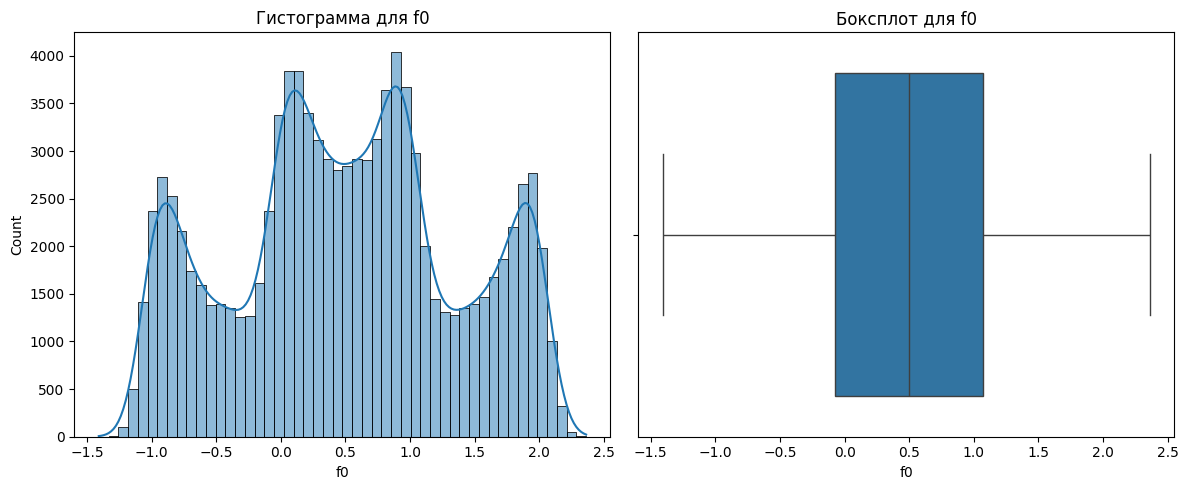

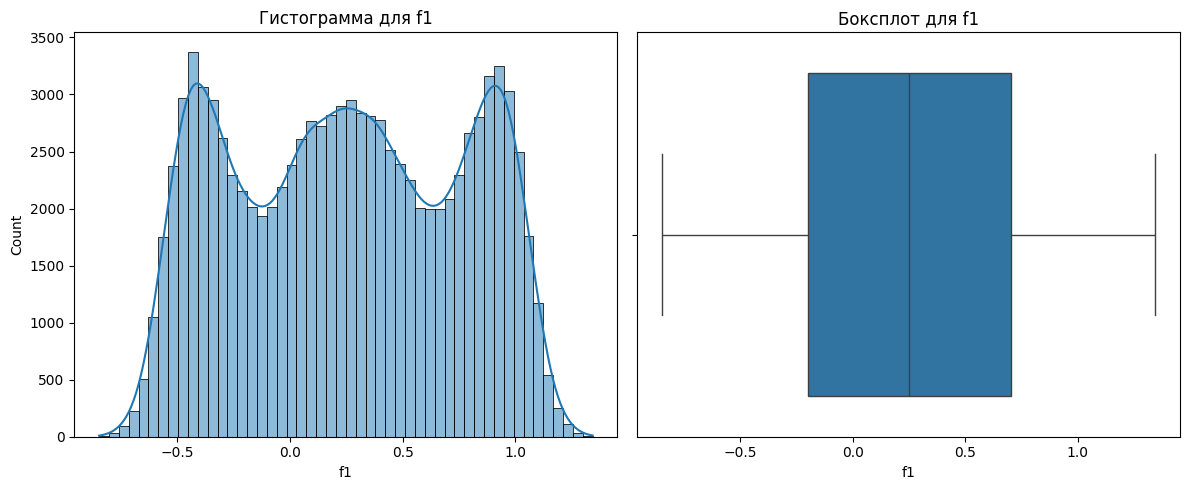

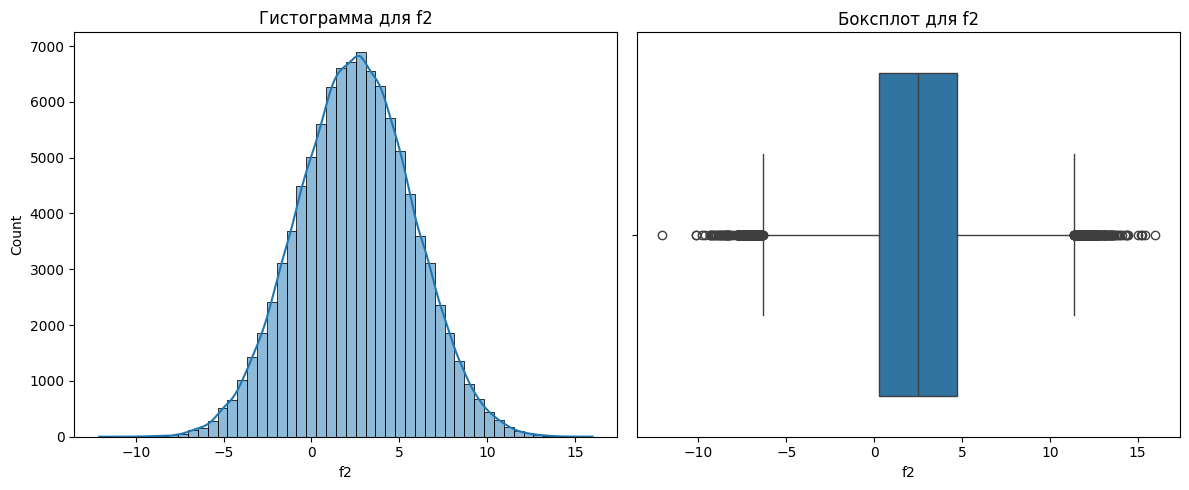

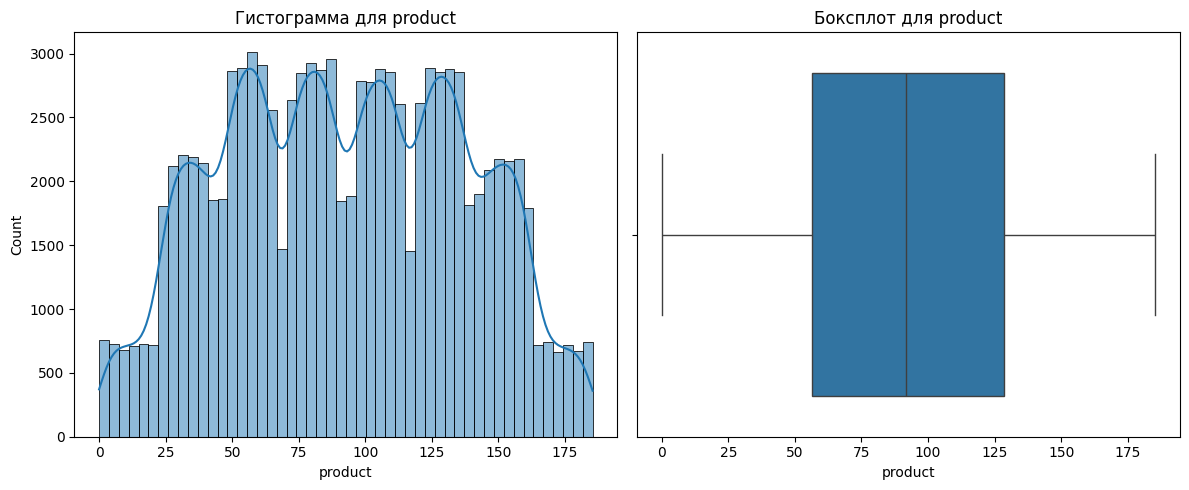

In [11]:
plotting_stat_graphs(data_0)

Куполообразным распределением обладает только признак `f2`. При этом в данных все признаки количественные, поэтому для исследования корреляции можно воспользоваться корреляцией Спирмена

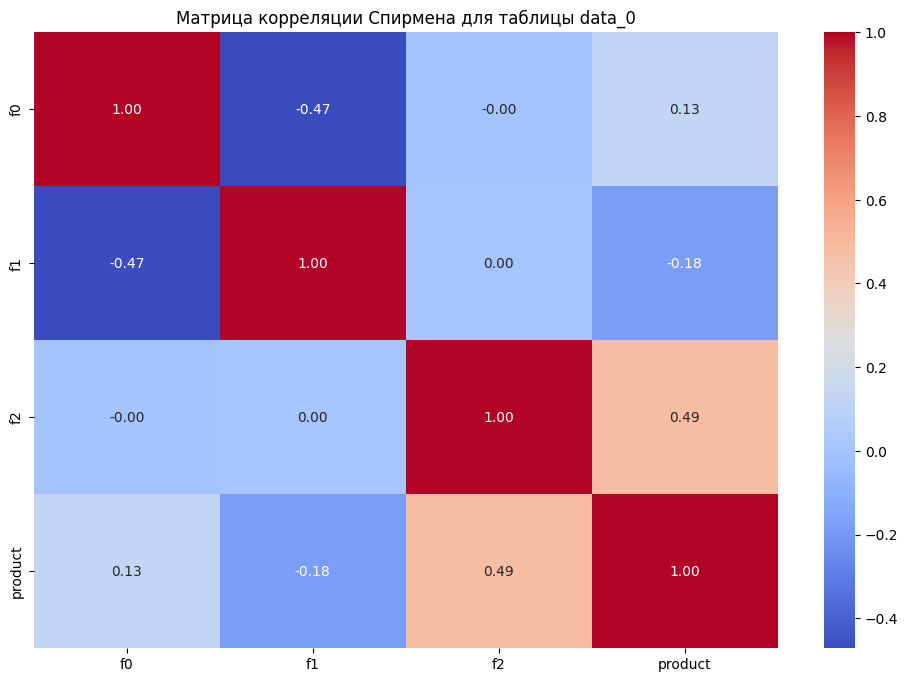

In [12]:
plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции Спирмена для таблицы data_0')
sns.heatmap(
    data_0.select_dtypes(include=["number"]).corr('spearman'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
);

Видим, что сильных корреляций у целевого признака нет. Повторим исследования для оставшихся таблиц

#### data_1

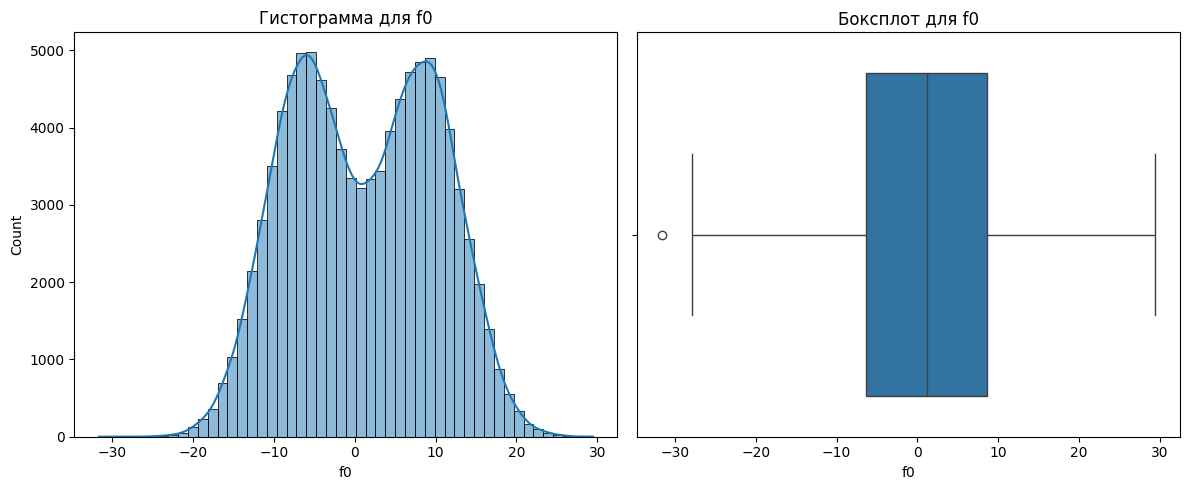

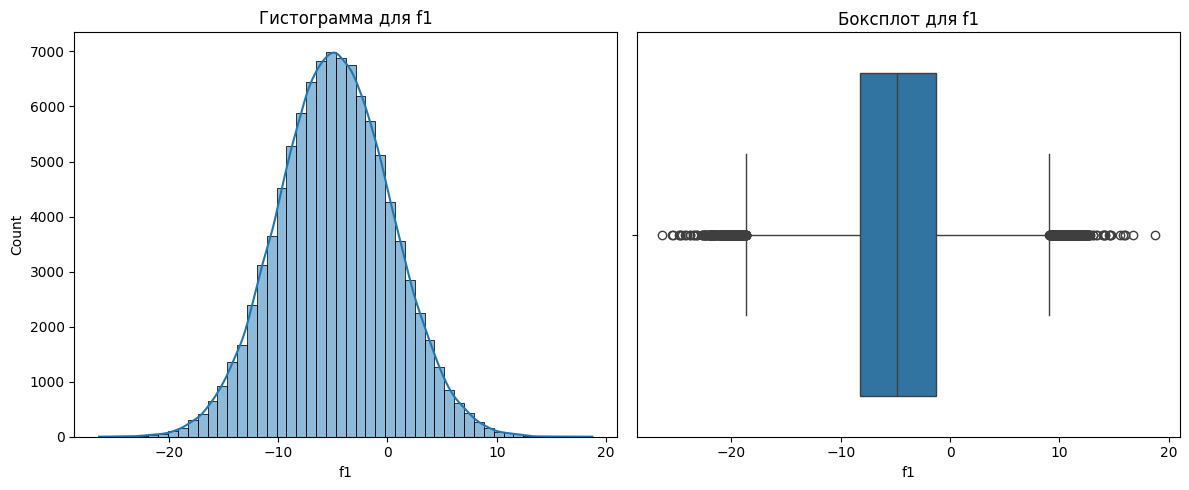

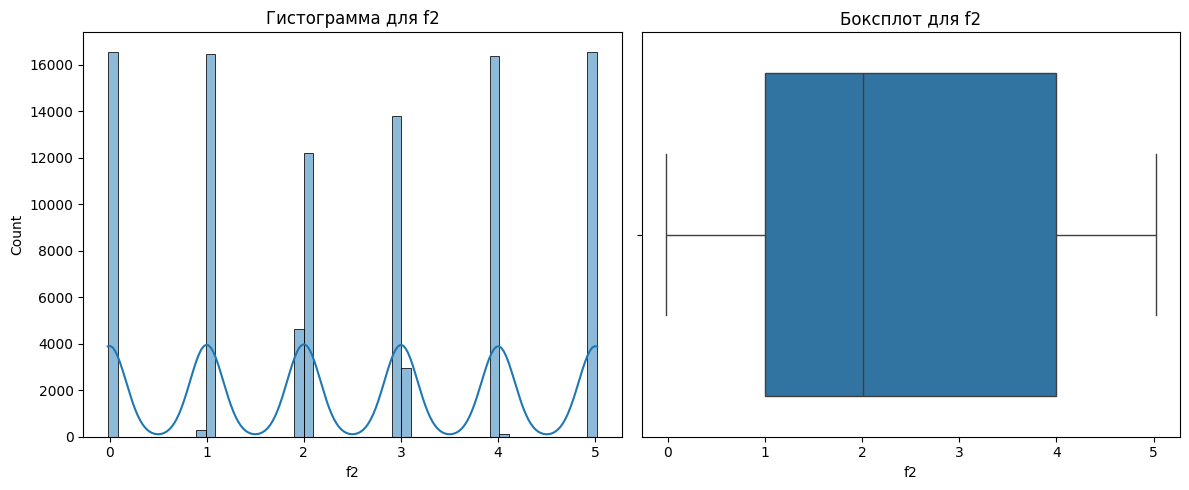

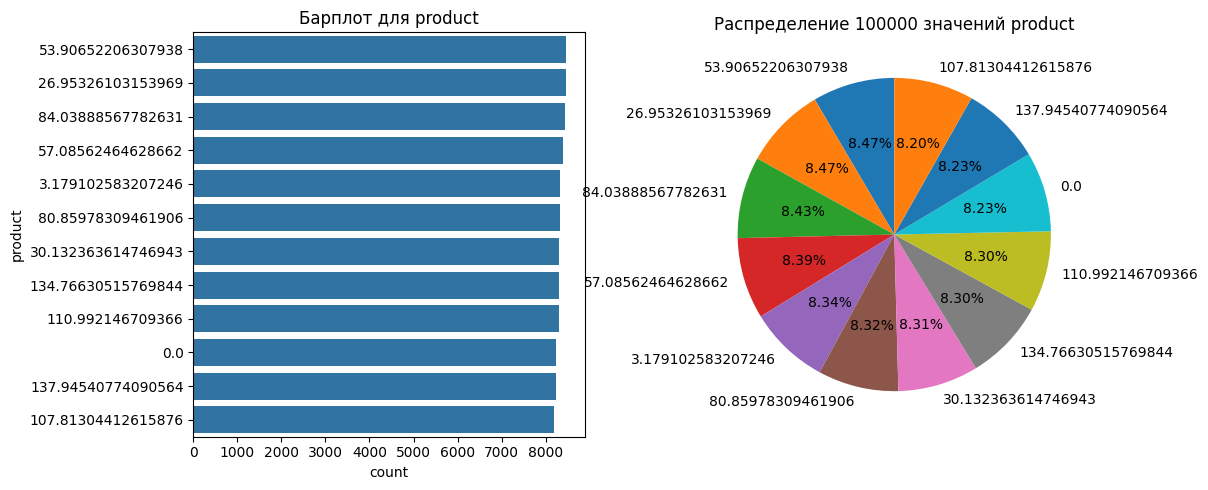

In [13]:
plotting_stat_graphs(data_1)

Эти данные похожи на искусственно сгенерированные - количество уникальных значений в `product` равно 12. При этом на нормальное распределение похоже только распределение `f1` - так что тоже пользуемся корреляцией Спирмена

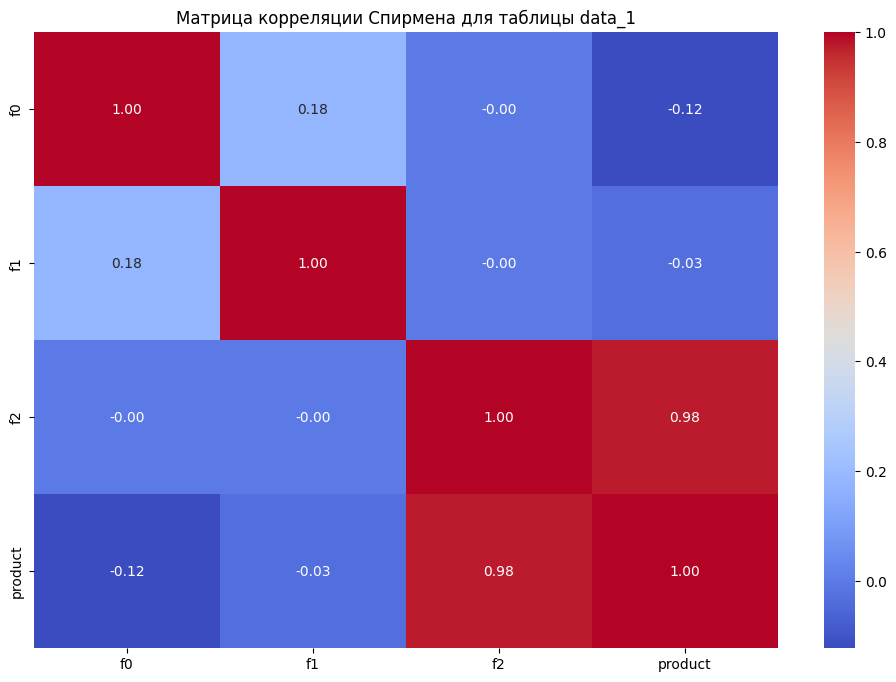

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции Спирмена для таблицы data_1')
sns.heatmap(
    data_1.select_dtypes(include=["number"]).corr('spearman'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
);

Здесь есть сильная корреляция (r = 0.98) между целевым признаком и f2. Можно посомтреть на эту зависимость

<Axes: xlabel='f2'>

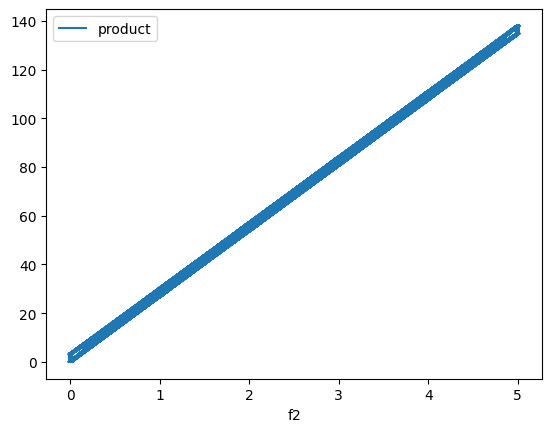

In [15]:
(
    data_1
    .plot(
        x='f2',
        y='product'
    )
)

Тут наблюдается линейная зависимость между входным признаком и целевым. Посмотрим на последнюю таблицу

#### data_2

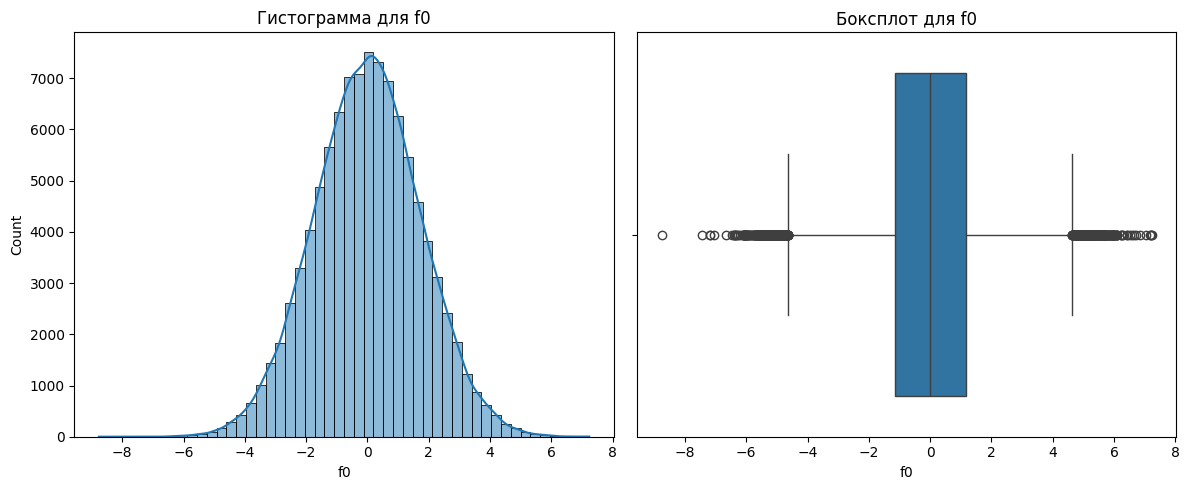

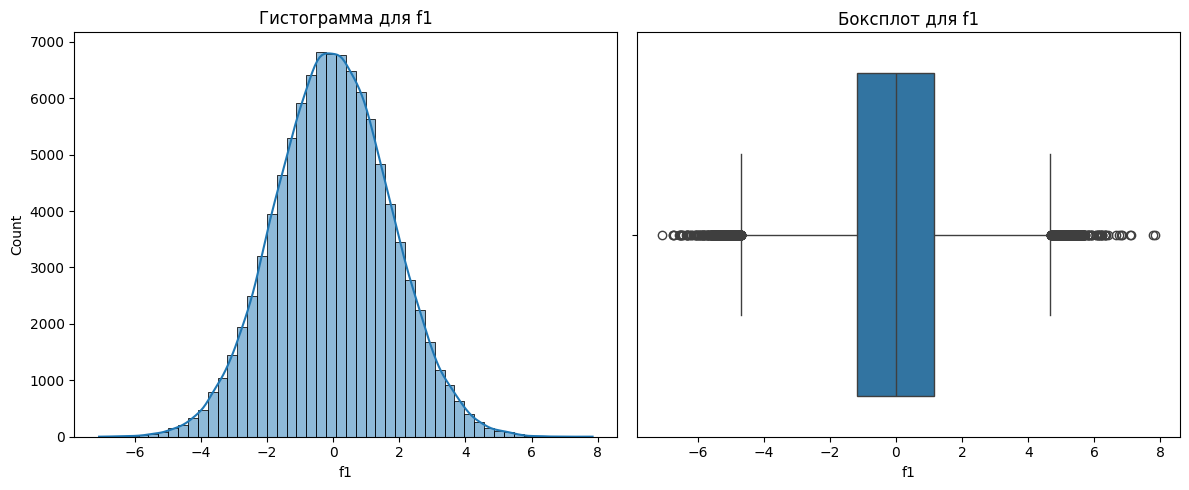

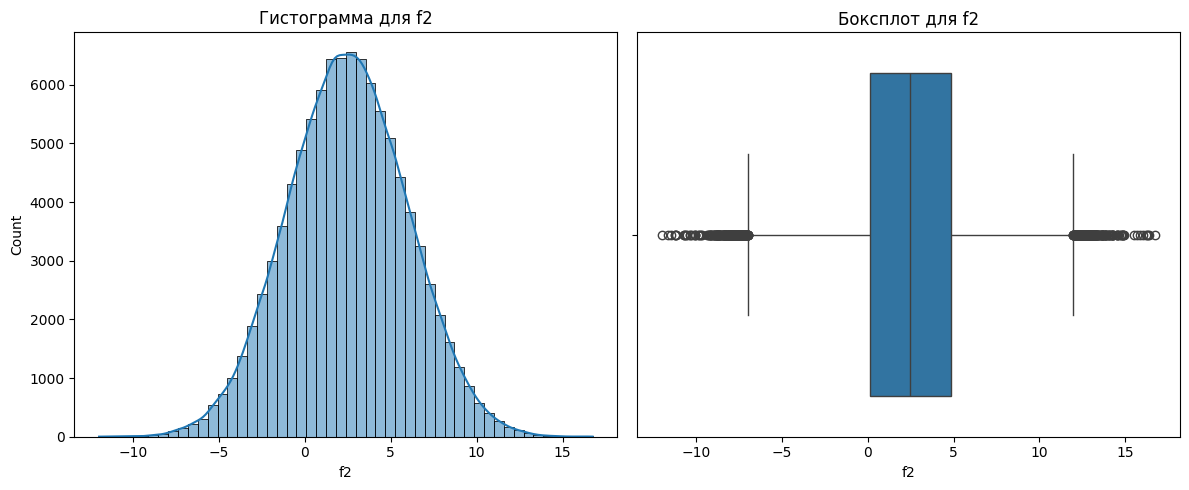

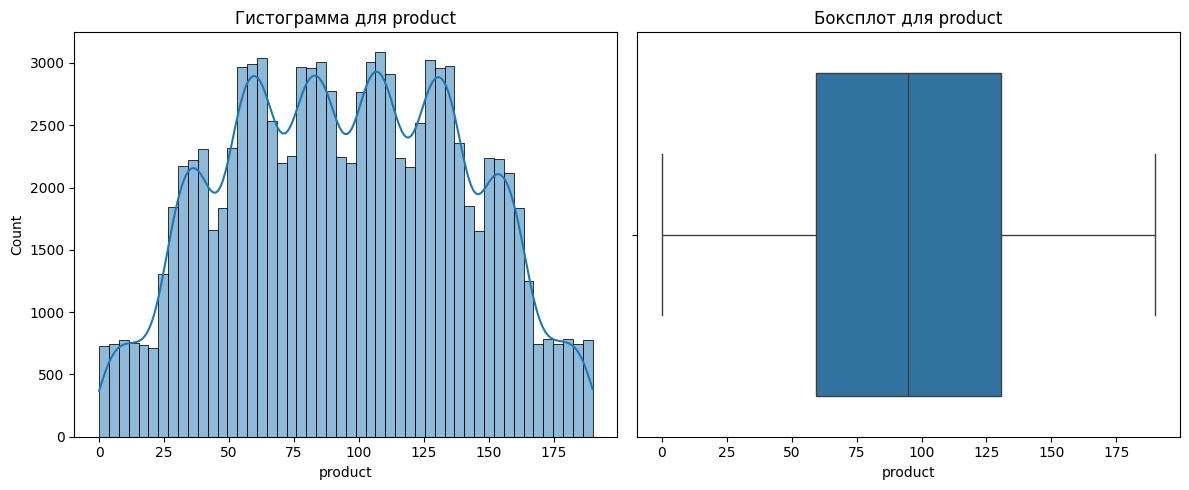

In [16]:
plotting_stat_graphs(data_2)

Тут входные признаки распределены куполообразно. Для проверки нормальность распределений проведем статистический тест Шапиро-Уилка:

$\text{H}_0$: Выборка $x_1, x_2, ..., x_n$ взята из нормально распределенной генеральной совокупности

$\text{H}_1$: Выборка $x_1, x_2, ..., x_n$ взята из не нормально распределенной генеральной совокупности

In [17]:
shapiro_results(data_2)

Тест Шапиро-Уилка для f0: p-value = 0.8468381521623489

Тест Шапиро-Уилка для f1: p-value = 0.7279626172951452

Тест Шапиро-Уилка для f2: p-value = 0.015432589863637883

Тест Шапиро-Уилка для product: p-value = 2.620217877870233e-69



c:\python\Data Science\DS_pracricum\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


Для `f0` и `f1` p-value > 0.05, то нельзя отвергать то, что значения взяты из нормально распределенной генеральной совокупности. Для этих величин посмотри на корреляцию Пирса

In [18]:
data_2['f0'].corr(data_2['f1'])

np.float64(0.0005282827065541881)

Нет корреляции между признаками. Построим также матрицу корреляции Спирмена для всех признаков

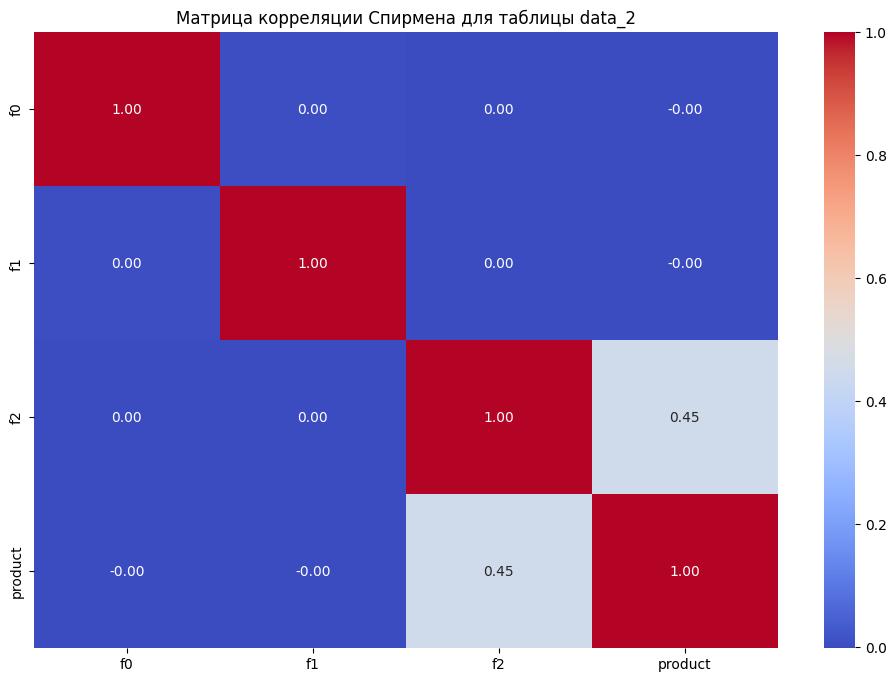

In [19]:
plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции Спирмена для таблицы data_2')
sns.heatmap(
    data_2.select_dtypes(include=["number"]).corr('spearman'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
);

Также нет сильных корреляций

#### Распределение запасов

Нанесем на один график распределение запасов сырья по трем регионам

Text(0.5, 1.0, 'Распределение объемов добычи в трех регионах')

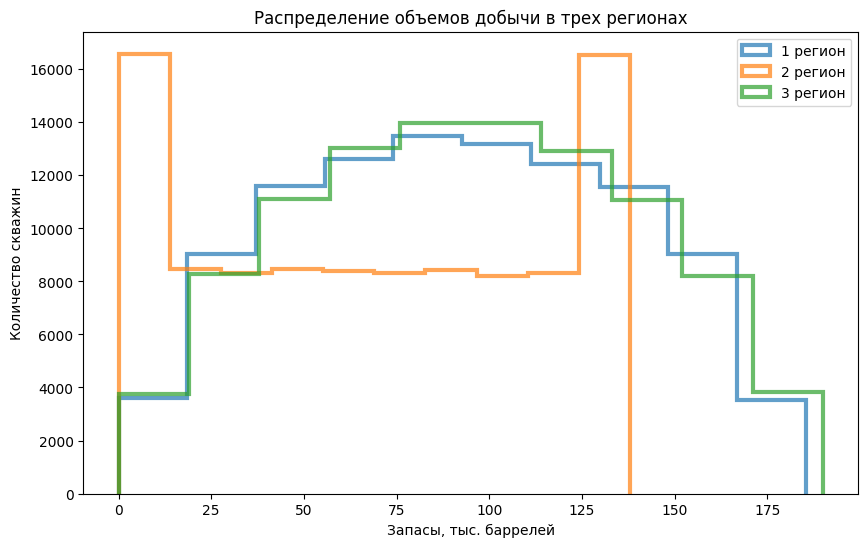

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

(
    data_0
    .loc[:, 'product']
    .plot(
        kind='hist',
        histtype='step',
        alpha=0.7,
        label='1 регион',
        linewidth=3,
        ax=ax,
        legend=True
    )
)
(
    data_1
    .loc[:, 'product']
    .plot(
        kind='hist',
        histtype='step',
        alpha=0.7,
        label='2 регион',
        linewidth=3,
        ax=ax,
        legend=True
    )
)
(
    data_2
    .loc[:, 'product']
    .plot(
        kind='hist',
        histtype='step',
        alpha=0.7,
        label='3 регион',
        linewidth=3,
        ax=ax,
        legend=True
    )
)

ax.set_ylabel('Количество скважин')
ax.set_xlabel('Запасы, тыс. баррелей')
ax.set_title('Распределение объемов добычи в трех регионах')

### Промежуточный вывод

Одни и те же признаки в разных регионах имеют различные распределения и внутренние свзяи: например, в data_1 есть линейная зависимость между `f2` и целевым признаком. При этом в data_0 и data_2 сильных корреляций нет вообще. При этом и распределения запасов в data_1 отличается от остальных регионов. При таких различиях стоит обучать три различные модели для трех различных регионов.

## Обучение и проверка модели

### Формирование подвыборок

Для начала разобъем данные на обучающую и валидационную выборки в соотношении 75:25.

In [21]:
X_0_train, X_0_valid, y_0_train, y_0_valid =\
my_split(data_0, random=RANDOM_STATE)

Общее количество наблюдений: 100000
X_train: 75000 (75.00%)
X_valid: 25000 (25.00%)
y_train: 75000 (75.00%)
y_valid: 25000 (25.00%)

Соотношение train/valid: 3:1


In [22]:
X_1_train, X_1_valid, y_1_train, y_1_valid =\
my_split(data_1, random=RANDOM_STATE)

Общее количество наблюдений: 100000
X_train: 75000 (75.00%)
X_valid: 25000 (25.00%)
y_train: 75000 (75.00%)
y_valid: 25000 (25.00%)

Соотношение train/valid: 3:1


In [23]:
X_2_train, X_2_valid, y_2_train, y_2_valid =\
my_split(data_2, random=RANDOM_STATE)

Общее количество наблюдений: 100000
X_train: 75000 (75.00%)
X_valid: 25000 (25.00%)
y_train: 75000 (75.00%)
y_valid: 25000 (25.00%)

Соотношение train/valid: 3:1


### Обучение моделей

Обучим модель и сделаем предсказания на валидационной выборке, а так же оценим качество модели с помощью метрик $RMSE$ и $R^2$

#### 1 регион

In [24]:
model_0 = LinearRegression()
model_0.fit(X_0_train, y_0_train)
pred_0 = model_0.predict(X_0_valid)
rmse_0 = root_mean_squared_error(y_0_valid, pred_0)
r2_0 = r2_score(y_0_valid, pred_0)
mean_product_0 = pred_0.mean()

print(f'Среднеквадратичная ошибка RMSE: {rmse_0:.2f}')
print(f'Коэффициент детерминации: {r2_0:.2f}')
print(f'Средний запас предсказанного сырья: {mean_product_0:.2f}')

Среднеквадратичная ошибка RMSE: 37.76
Коэффициент детерминации: 0.27
Средний запас предсказанного сырья: 92.40


#### 2 регион

In [25]:
model_1 = LinearRegression()
model_1.fit(X_1_train, y_1_train)
pred_1 = model_1.predict(X_1_valid)
rmse_1 = root_mean_squared_error(y_1_valid, pred_1)
r2_1 = r2_score(y_1_valid, pred_1)
mean_product_1 = pred_1.mean()

print(f'Среднеквадратичная ошибка RMSE: {rmse_1:.2f}')
print(f'Коэффициент детерминации: {r2_1:.2f}')
print(f'Средний запас предсказанного сырья: {mean_product_1:.2f}')

Среднеквадратичная ошибка RMSE: 0.89
Коэффициент детерминации: 1.00
Средний запас предсказанного сырья: 68.71


#### 3 регион

In [26]:
model_2 = LinearRegression()  
model_2.fit(X_2_train, y_2_train)  
pred_2 = model_2.predict(X_2_valid)  
rmse_2 = root_mean_squared_error(y_2_valid, pred_2)  
r2_2 = r2_score(y_2_valid, pred_2)  
mean_product_2 = pred_2.mean()  

print(f'Среднеквадратичная ошибка RMSE: {rmse_2:.2f}')  
print(f'Коэффициент детерминации: {r2_2:.2f}')  
print(f'Средний запас предсказанного сырья: {mean_product_2:.2f}')

Среднеквадратичная ошибка RMSE: 40.15
Коэффициент детерминации: 0.20
Средний запас предсказанного сырья: 94.77


### Промежуточные выводы

Данные, полученные из трех регионов, были разделены на валидационную и тренировочную части в соотношении 1:3. На этих данных были обучены три модели линейной регрессии, их качество было проверено на валидационной выборке. Результаты занесены в таблицу:

Вот таблица в формате Markdown на основе предоставленных данных:


| Регион | Среднеквадратичная ошибка (RMSE) | Коэффициент детерминации (R²) | Средний запас предсказанного сырья |
|--------|----------------------------------|-------------------------------|-------------------------------------|
| 1      | 37.76                            | 0.27                          | 92.40                              |
| 2      | 0.89                             | 1.00                          | 68.71                              |
| 3      | 40.15                            | 0.20                          | 94.77                              |

Результаты согласуются с предварительным анализом, согласно которому, только в data_1, соответствующей 2 региону, наблюдалась сильная линейная зависимость между входным признаком `f2` и целевым признаком `product`. При этом в данных из других регионов сильных корреляций не было, что мы видим по величине ошибок.  

## Подготовка к расчёту прибыли

### Определение основных значений

У задачи нам заданы следующие условия:

* При разведке региона исследуюем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — **10 млрд. рублей**.
* При нынешних ценах один баррель сырья приносит **450 рублей** дохода. Доход с каждой единицы продукта составляет **450 тыс. рублей**, поскольку объём указан в тысячах баррелей.
* После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше **2.5%**. Среди них выберем регион с наибольшей средней прибылью.

Сохраним в переменные все основные значения:

In [27]:
budget = 1e7 # тыс. рублей - бюджет
revenue_per_unit = 450 # тыс. рублей / тыс. баррелей - доход с единицы продукта
probability_of_losses = 2.5e-2 # вероятность убытков
number_of_point = 200 # число искомых точек

### Рассчет достаточного объема сырья для безубыточной разработки новой скважины (ДОС)

$$\text{Бюджет на одну скважину} = \frac{\text{Бюджет}}{\text{Число точек}}$$
$$\text{ДОС} = \frac{\text{Бюджет на одну скважину}}{\text{Доход с единицы продукта}}$$

In [28]:
budget_for_point = budget / number_of_point
sufficient_volume = budget_for_point / revenue_per_unit

print(f'Бюджет на одну скважину: {budget_for_point:.2f} тыс. рублей')
print(f'Достаточный объем сырья: {sufficient_volume:.2f} тыс. баррелей')

Бюджет на одну скважину: 50000.00 тыс. рублей
Достаточный объем сырья: 111.11 тыс. баррелей


In [29]:
analysis_table = pd.DataFrame(
    {
        'Регион': [1, 2, 3],
        'Средний объем сырья, тыс. баррелей': [mean_product_0, mean_product_1, mean_product_2],
        'Достаточный объем сырья, тыс. баррелей': [sufficient_volume] * 3
    }
).set_index('Регион')

analysis_table['Выручка, тыс. рублей'] =\
    analysis_table['Средний объем сырья, тыс. баррелей'] * revenue_per_unit

analysis_table['ROI, %'] =\
(analysis_table['Выручка, тыс. рублей'] - budget_for_point) / budget_for_point\
*100

analysis_table.round(2)

,"Средний объем сырья, тыс. баррелей","Достаточный объем сырья, тыс. баррелей","Выручка, тыс. рублей","ROI, %"
Регион,,,,
1,92.40,111.11,41579.46,-16.84
2,68.71,111.11,30920.80,-38.16
3,94.77,111.11,42646.96,-14.71


### Промежуточный вывод

Краткий бизнес анализ полученных данных показывает, что среднего количества получаемого сырья в регионах недостаточно для окупаемости разработки (возврат на инвестиции отрицательный). Поэтому важно выбирать скважины с максимальными запасами

## Функция для расчета прибыли по выбранным скважинам и предсказаниям модели

In [30]:
def profit_calculation(
        pred: np.array,
        indexs: pd.core.indexes.base.Index,
        verbose: bool = True
) -> Tuple[float, float]:
    '''
    На вход подается предсказание модели и соответсвтующие индексы точек
    Функция выводит суммарный запас сырья в лучших скважинах и суммарную 
    прибыль с этой добычи
    '''
    # Привязка индексов к предсказанным добычам и сортировка по убыванию добычи
    pred = pd.Series(pred, index=indexs).sort_values(ascending=False)

    # Суммирование добычи у лучших точек
    total_production = pred[:number_of_point].sum() # тыс. баррелей

    # Вычисление дохода с этой добычи
    total_profit = total_production * revenue_per_unit - budget# тыс. рублей
   
    if verbose:
         print(f'Суммарный запас сырья в {number_of_point}\
 лучших скважинах составит: {total_production:.2f} тыс. баррелей')
         
         print(f'Суммарный доход от {number_of_point}\
 лучших скважин составит: {total_profit:.2f} тыс. рублей')
    return total_production, total_profit

In [31]:
total_production_0, total_profit_0 = profit_calculation(pred_0, X_0_valid.index)

Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс. баррелей
Суммарный доход от 200 лучших скважин составит: 3896658.48 тыс. рублей


In [32]:
total_production_1, total_profit_1 = profit_calculation(pred_1, X_1_valid.index)

Суммарный запас сырья в 200 лучших скважинах составит: 27748.75 тыс. баррелей
Суммарный доход от 200 лучших скважин составит: 2486938.11 тыс. рублей


In [33]:
total_production_2, total_profit_2 = profit_calculation(pred_2, X_2_valid.index)

Суммарный запас сырья в 200 лучших скважинах составит: 29728.85 тыс. баррелей
Суммарный доход от 200 лучших скважин составит: 3377981.51 тыс. рублей


### Промежуточные выводы

Все три региона потенциально принесут прибыль. Дальнейший вероятностный анализ покажет риски и прибыль для каждого региона

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона:
С помощью техники Bootstrap с 1000 выборок найдем распределение прибыли, среднюю прибыль, 95%-й доверительный интервал и риск убытков. 

*Убыток — это отрицательная прибыль.

In [34]:
def bootstrap(
        pred: np.array,
        target: pd.Series,
        number_of_samples: int = 1000,
        size_of_sample: int = 500,
        confidence_interval_percent: float = 0.95
) -> Tuple[float, float, float, float]:
    '''
    Функция на вход получает предсказание модели и реальные значения добычи
    Функция строит распределение прибыли, ее срденее значение, доверительный 
    интервал и риск убытков
    '''

    loss = 0
    profits = []
    state = np.random.RandomState(12345)

    pred = pd.Series(pred, index=target.index)

    for i in tqdm(range(number_of_samples)):
        target_subsamp = target.sample(
            n=size_of_sample, 
            replace=True,
            random_state=state
        )
        pred_subsamp = pred[target_subsamp.index]
        profit = target_subsamp[
            pred_subsamp.sort_values(ascending=False)[:number_of_point].index
        ].sum() * revenue_per_unit - budget
        profits.append(profit)
        if profit < 0:
            loss += 1
        
    profits = pd.Series(profits)
    mean_profit = profits.mean()
    loss_proba = loss / len(profits)

    confidence_interval = st.t.interval(
        confidence_interval_percent,
        len(profits) - 1,
        mean_profit,
        st.sem(profits) 
    )

    plt.title('Распределение прибыли')
    (profits / 1000).plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, млн. рублей')
    plt.ylabel('Частота')
    plt.show()

    print(f'Средняя прибыль: {mean_profit / 1000:.2f} млн. рублей')
    print(f'{confidence_interval_percent * 100:.0f}% доверительный интервал\
: [{confidence_interval[0] / 1000:.2f}, {confidence_interval[1] / 1000:.2f}]\
 млн. рублей')
    print(f'Вероятность убытка: {loss_proba:.2%}')

    return (
        mean_profit / 1000, 
        confidence_interval_percent * 100,
        (confidence_interval[0] / 1000, confidence_interval[1] / 1000),
        loss_proba
    )


100%|██████████| 1000/1000 [00:00<00:00, 1131.77it/s]


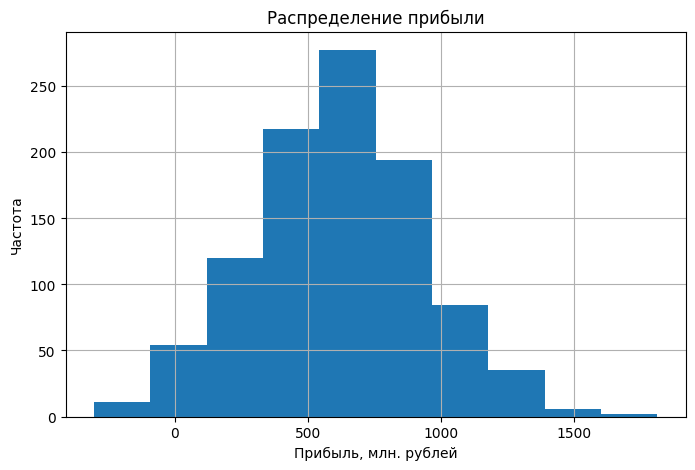

Средняя прибыль: 615.05 млн. рублей
95% доверительный интервал: [595.12, 634.97] млн. рублей
Вероятность убытка: 3.00%


In [35]:
(
    mean_profit_0,
    confidence_interval_percent_0,
    confidence_interval_0,
    loss_proba_0
) = bootstrap(pred_0, y_0_valid)

100%|██████████| 1000/1000 [00:00<00:00, 1183.13it/s]


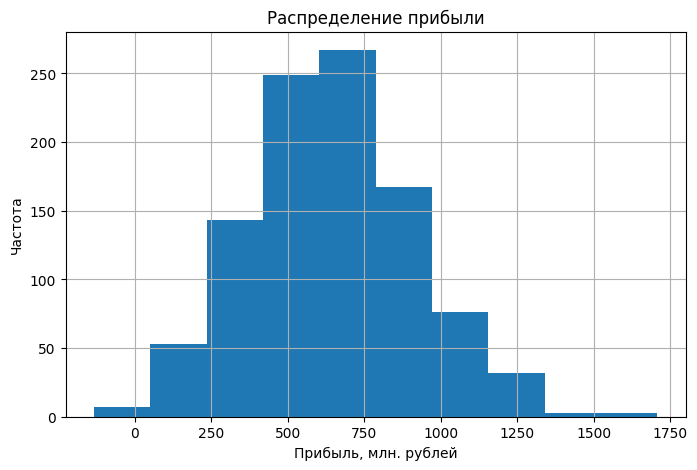

Средняя прибыль: 639.64 млн. рублей
95% доверительный интервал: [622.92, 656.35] млн. рублей
Вероятность убытка: 0.40%


In [36]:
(
    mean_profit_1,
    confidence_interval_percent_1,
    confidence_interval_1,
    loss_proba_1
) = bootstrap(pred_1, y_1_valid)

100%|██████████| 1000/1000 [00:00<00:00, 1171.42it/s]


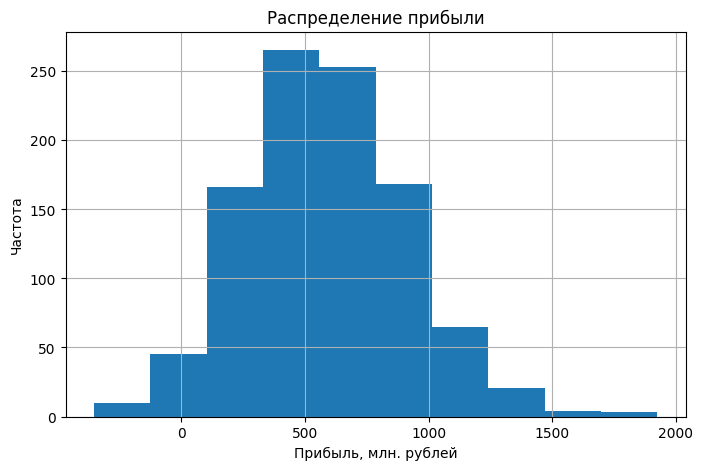

Средняя прибыль: 587.11 млн. рублей
95% доверительный интервал: [566.98, 607.23] млн. рублей
Вероятность убытка: 2.60%


In [37]:
(
    mean_profit_2,
    confidence_interval_percent_2,
    confidence_interval_2,
    loss_proba_2
) = bootstrap(pred_2, y_2_valid)

In [38]:
confidence_interval_2

(np.float64(566.9826920525369), np.float64(607.2299975391954))

In [39]:
comparison_table = pd.DataFrame(
    {
        'Регион': ['Регион 0', 'Регион 1', 'Регион 2'],
        'Средняя прибыль, млн. рублей': [
            mean_profit_0.round(2), 
            mean_profit_1.round(2), 
            mean_profit_2.round(2)],
        f'{confidence_interval_percent_0:.0f} доверительный интервал, млн. рублей': [
            f'[{confidence_interval_0[0]:.1f}, {confidence_interval_0[1]:.1f}]',
            f'[{confidence_interval_1[0]:.1f}, {confidence_interval_1[1]:.1f}]',
            f'[{confidence_interval_2[0]:.1f}, {confidence_interval_2[1]:.1f}]'
        ],
        'Вероятность убытков, %': [
            loss_proba_0 * 100, 
            loss_proba_1 * 100, 
            loss_proba_2 * 100]
    }
).set_index('Регион')

comparison_table

,"Средняя прибыль, млн. рублей","95 доверительный интервал, млн. рублей","Вероятность убытков, %"
Регион,,,
Регион 0,615.05,"[595.1, 635.0]",3.0
Регион 1,639.64,"[622.9, 656.4]",0.4
Регион 2,587.11,"[567.0, 607.2]",2.6


По полученным данным, самым прибыльным оказался 2 регион, средняя прибыль в котором составила 615.05 млн. рублей. Два других региона не прошли порог вероятности убытка в 2.5%. Таким образом, несмотря на то, что среднее количество запасов сырья в этом регионе было наименьшим, прогнозируемая доходность этого региона оказалась лидирующей. 

Тут стоит отметить, что при построении линейной модели, мы получили в других регионах сильно большую ошибку, так как входные данные не имели такой четкой линейной зависимости, как второй регион. Возможно, что применение более точных моделей поможет максимизировать прибыль и с двух других регионов.

## Вывод

В рамках проекта была проведена работа по выбору оптимального региона для бурения новых нефтяных скважин компании "ГлавРосГосНефть" с использованием методов машинного обучения. 

Исследованы данные из трех регионов, каждый из которых включал 100 000 образцов скважин с признаками f0, f1, f2 и целевой переменной 'product' (объем запасов нефти). Второй регион показал наименьшие средние запасы (68.8 тыс. баррелей против 92.5 и 95), но модель линейной регрессии для этого региона оказалась наиболее точной ($\text{R}^2$ = 1,00, RMSE = 0,89), в то время как регионы 1 и 3 имели менее точные предсказания (R² ≈ 0,20-0,27, RMSE ≈ 37-40). Данное различие объясняется исключительным проявлением линейной зависимости между `f2` и целевым признаком во втором регионе, чего не наблюдается в оставшихся.

Первоначальные расчеты прибыли на основе выбора 200 лучших предсказанных скважин показали более высокие значения для регионов 0 и 2. Однако анализ с использованием метода Bootstrap, который учитывает неопределенность предсказаний, выявил, что второй регион обеспечивает наивысшую среднюю прибыль (639,64 млн рублей) при самом низком риске потерь (0,40%), что ниже установленного порога в 2,5%. Регионы 1 и 3, напротив, имеют риски потерь 3,00% и 2,60% соответственно, что делает регион их неприемлемыми для поставленной задачи.

На основе проведенного анализа рекомендуется выбрать второй регион для разработки новых скважин. Несмотря на более низкие средние запасы, высокая точность модели позволяет надежно выбирать наиболее прибыльные скважины, минимизируя риски.